# Predict Avocado Prices



The project consists of the following:

1. Introduction 

   1.1  Importing libraries and fata 
   
   
2. Data Preprocessing and Visualization

   2.1 Prepare Data For Time Series Analysis 
       
   2.2 Exploratory Data Analysis
   
   2.3 Decomposition
   
   2.4 Stationarity- ACF and PACF plots
   


3. Time Series forecasting With Seasonal ARIMA
   
   3.1 Deviding Data Into Train And Validation Set
   
   3.2 Finding The Optimal Model Using Grid Search
   
   3.3 Model Evaluation



4. Actionable Recommendations

   4.1 Summary Of Findings
   
   4.2 Recommendations For Avocado Lovers



## 1. Introduction

Avocados are a staple in many people's diet. Whether it's warm avocado toast in winter or guacamole drizzled with olive oil in summer, avocado has been our our all time favorite. For the past decades, our appetite for avocados have only risen. In 2000, Americans were consuming a little more than 1 billion avocados, and that number has since exploded, reaching nearly 5 billion. 

However, avocado prices can vary quite a bit throughout the year. During certain time of the year, they can be quite expensive for foodies. In this project, we'll explore the underlying trends and patterns of avocado prices, and then develop the optimal SARIMA model to forecast the average prices over the next two years. 

### 1.1 Importing Libraries And Data  

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import scipy
from math import sqrt
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')


from dateutil.parser import parse
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error
from sklearn.model_selection import cross_val_score

# parallel processing
import multiprocessing as mp
print("6: ", mp.cpu_count())

6:  8


In [2]:
avo = pd.read_csv('avocado.csv')

In [3]:
avo.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,12/27/2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,12/20/2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,12/13/2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,12/6/2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,11/29/2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


## 2. Data Preprocessing and Visualization

In [4]:
# drop the first column
avo = avo.drop(['Unnamed: 0'],axis = 1) 
avo.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,12/27/2015,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,12/20/2015,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,12/13/2015,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,12/6/2015,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,11/29/2015,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [5]:
avo.describe()

,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,year
count,18249.000000,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,1.824900e+04,18249.000000,18249.000000
mean,1.405978,8.506440e+05,2.930084e+05,2.951546e+05,2.283974e+04,2.396392e+05,1.821947e+05,5.433809e+04,3106.426507,2016.147899
std,0.402677,3.453545e+06,1.264989e+06,1.204120e+06,1.074641e+05,9.862424e+05,7.461785e+05,2.439660e+05,17692.894652,0.939938
min,0.440000,8.456000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,2015.000000
25%,1.100000,1.083858e+04,8.540700e+02,3.008780e+03,0.000000e+00,5.088640e+03,2.849420e+03,1.274700e+02,0.000000,2015.000000
50%,1.370000,1.073768e+05,8.645300e+03,2.906102e+04,1.849900e+02,3.974383e+04,2.636282e+04,2.647710e+03,0.000000,2016.000000
75%,1.660000,4.329623e+05,1.110202e+05,1.502069e+05,6.243420e+03,1.107834e+05,8.333767e+04,2.202925e+04,132.500000,2017.000000
max,3.250000,6.250565e+07,2.274362e+07,2.047057e+07,2.546439e+06,1.937313e+07,1.338459e+07,5.719097e+06,551693.650000,2018.000000


In [6]:
avo.isnull().sum()

Date            0
AveragePrice    0
Total Volume    0
4046            0
4225            0
4770            0
Total Bags      0
Small Bags      0
Large Bags      0
XLarge Bags     0
type            0
year            0
region          0
dtype: int64

### 2.1 Prepare Data for Time Series Analysis

In [7]:
# convert Date from object to datetime 
avo['Date'] = pd.to_datetime(avo['Date'])
avo.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [8]:
# create month and day columns
avo['month'] = pd.DatetimeIndex(avo['Date']).month
avo['day'] = pd.DatetimeIndex(avo['Date']).day
avo.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,month,day
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany,12,27
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany,12,20
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany,12,13
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany,12,6
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany,11,29


## 2.2 Exploratory Data Analysis

Text(0.5, 1.0, 'Total Sales Volume of Avocado by Type')

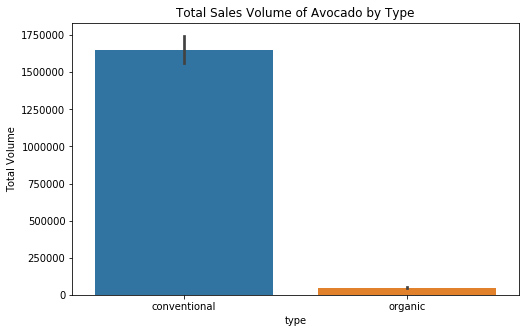

In [9]:
plt.figure(figsize=(8,5))
ax = sns.barplot(x='type', y='Total Volume', data=avo)
plt.title('Total Sales Volume of Avocado by Type')

Conventional avocados account for the majority of the sales volume in the country. 

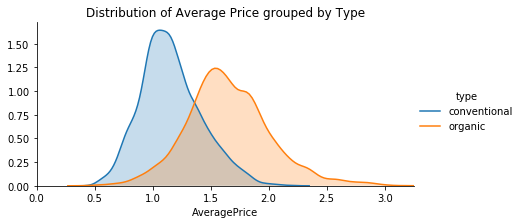

In [10]:
fig = sns.FacetGrid(avo, hue='type', aspect=2)
fig.map(sns.kdeplot, 'AveragePrice', shade=True)
oldest = avo['AveragePrice'].max()
fig.set(xlim=(0,oldest))
fig.set(title='Distribution of Average Price grouped by Type')
fig.add_legend()

The distribution of the average price of conventional avocados has a peak around 1.2. The average price of organic avocados has a wider range with a peak between 1.5-1.75.  

Text(0.5, 1.0, 'Average Price 2015-2018')

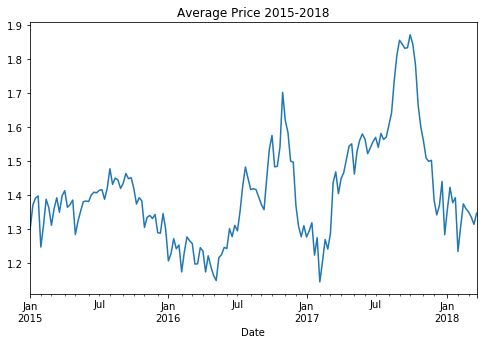

In [11]:
dategroup=avo.groupby('Date').mean()
fig, ax = plt.subplots(figsize=(8,5))
dategroup['AveragePrice'].plot(x=avo.Date)
plt.title('Average Price 2015-2018') 

In 2015, the average price peaked in August and October but the range doesn't vary a lot. In 2016 and 2017, the average price has a significant peak in October and December, and then it drops dramaticallly in December and January.  

Text(0.5, 1.0, 'Average Price by Month')

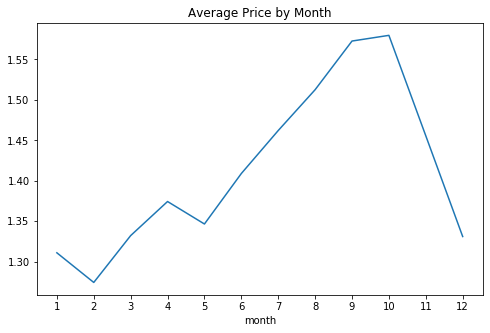

In [12]:
monthgroup=avo.groupby('month').mean()
fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set(ticks=range(0,13)) 
monthgroup['AveragePrice'].plot(x=avo.month)
plt.title('Average Price by Month')   

If we look at the distribution of the average price grouped by month from 2015-2018, prices start to go up after May and reaches its highest in October, and it starts to drop and is lowest in February. 

Text(0.5, 1.0, 'Average Price by Day')

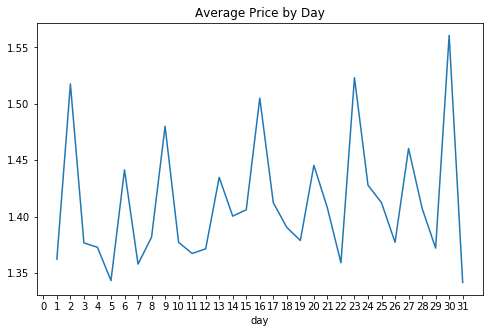

In [13]:
daygroup=avo.groupby('day').mean()
fig, ax = plt.subplots(figsize=(8,5))
ax.xaxis.set(ticks=range(0,32)) 
daygroup['AveragePrice'].plot(x=avo.day)
plt.title('Average Price by Day')

The average price fluctuates through out the month and every cycle is about 5 days. It reaches the highest point at the end of the month.  

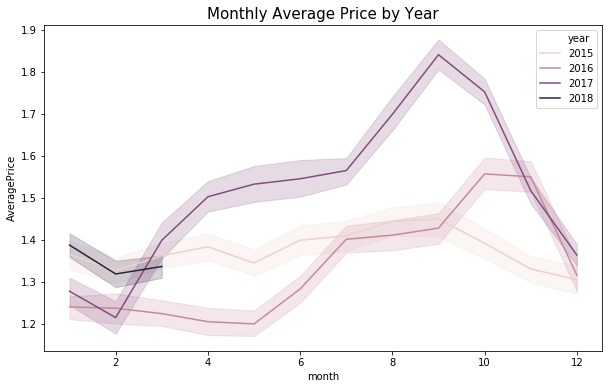

In [14]:
plt.figure(figsize=(10,6))
sns.lineplot(x="month", y="AveragePrice", hue='year',  data=avo)
plt.title("Monthly Average Price by Year",{'fontsize':15})
plt.show()

The monthly average price in 2015 ranges between $1.3-$1.5 without much fuctuation. In 2016 and 2017, there are seasonal patterns where the average price keeps going up in spring/summer and starts going down after its peak around October. We can see the distribution for 2017 has an usual highest peak in September and then it abruptly drops. It indicates there might be a special event that caused the sudden fluctuation.      
We only have the data till March 2018 so we can't see the distribution for the whole year.      

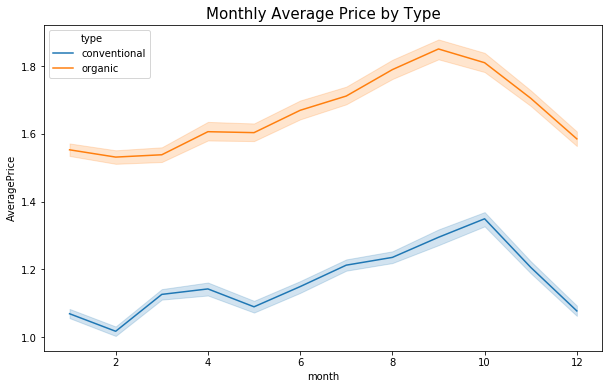

In [15]:
plt.figure(figsize=(10,6))
sns.lineplot(x="month", y="AveragePrice", hue='type',  data=avo)
plt.title("Monthly Average Price by Type",{'fontsize':15})
plt.show()

Both organic and conventional avocados are the most expensive during the fall and then the price drops to the lowest point in winter.

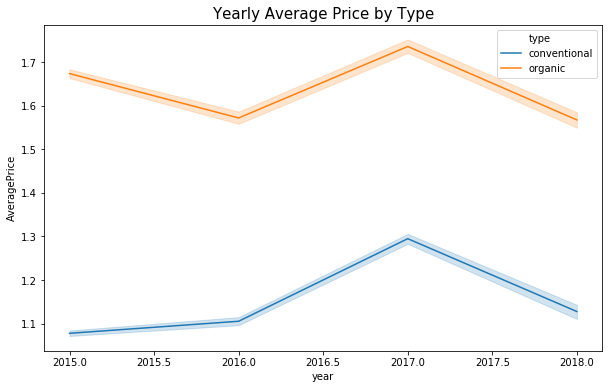

In [16]:
plt.figure(figsize=(10,6))
sns.lineplot(x="year", y="AveragePrice", hue='type',  data=avo)
plt.title("Yearly Average Price by Type",{'fontsize':15})
plt.show()

The distributions of the average price for conventional and organic avocados follow pretty much the same pattern after 2016, which indicates that type  doesn't have a significant impact on fuctuations of the price either on a yearly or monthly basis.  

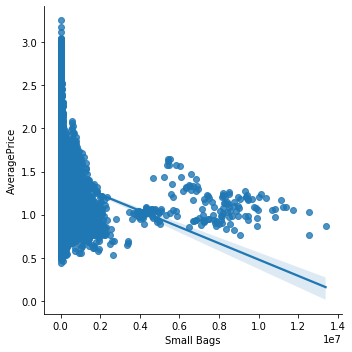

In [17]:
sns.lmplot(x="Small Bags", y="AveragePrice", data=avo)

(array([-1000000.,        0.,  1000000.,  2000000.,  3000000.,  4000000.,
         5000000.,  6000000.,  7000000.]),
 <a list of 9 Text xticklabel objects>)

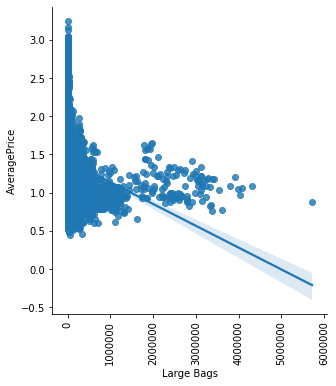

In [18]:
sns.lmplot(x="Large Bags", y="AveragePrice", data=avo)
plt.xticks(rotation=90)

The average price decreases as sales volume increases for both small and large bags.  

Text(0.5, 1.0, 'Average Price of Avocado by Region')

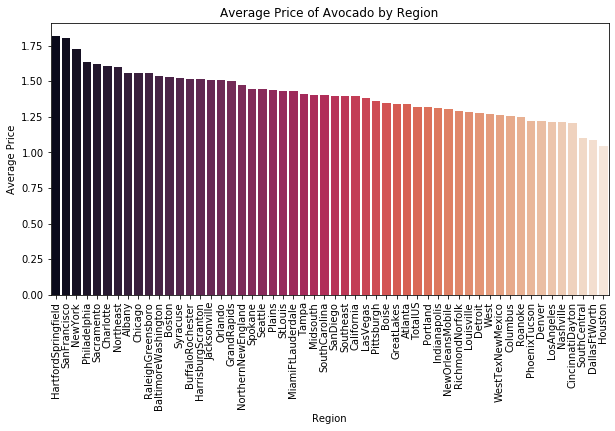

In [19]:
region_list=list(avo.region.unique())
average_price_region=[]

for i in region_list:
    x=avo[avo.region==i]
    average_price_region.append(sum(x.AveragePrice)/len(x))
df=pd.DataFrame({'region_list':region_list,'average_price':average_price_region})
df.sort_values('average_price', ascending = False, inplace= True)

plt.figure(figsize=(10,5))
ax=sns.barplot(x=df.region_list,y=df.average_price,palette='rocket')
plt.xticks(rotation=90)
plt.xlabel('Region')
plt.ylabel('Average Price')
plt.title('Average Price of Avocado by Region')

Avocados are the most expensive in the major cities on the east coast, and relatively cheaper in California and Texas, which makes sense because Mexico and California supplied most of the avocados in the U.S.

## 2.3 Decomposition

In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned. The decomposition of time series deconstructs a time series into several components, each representing one of the underlying categories of patterns, and we will be able to see the trend, seasonal, and residual components of our data.

In [20]:
df = avo.loc[:, ["Date","AveragePrice"]]
df = df.groupby('Date')['AveragePrice'].mean().reset_index()
df = df.set_index(pd.DatetimeIndex(df['Date']))

In [21]:
df.head()

,Date,AveragePrice
Date,,
2015-01-04,2015-01-04,1.301296
2015-01-11,2015-01-11,1.370648
2015-01-18,2015-01-18,1.391111
2015-01-25,2015-01-25,1.397130
2015-02-01,2015-02-01,1.247037


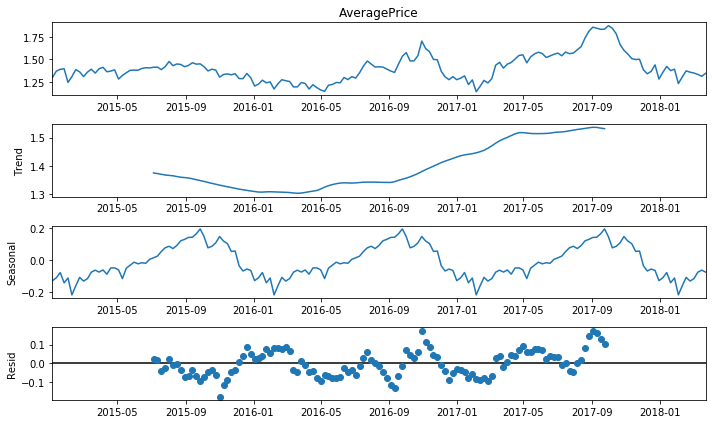

In [22]:
from pylab import rcParams

y = df['AveragePrice']
rcParams['figure.figsize'] = 10,6
decomposition = sm.tsa.seasonal_decompose(y, model = 'additive')
fig = decomposition.plot()
plt.show()

The average price of avocados starts dropping in July 2015 and then has an upward trend since July 2016. Also, there's very obvious sesonality in this data. Price is the highest in the falls and the lowest in winters.   

## 2.4 Stationarity: ACF and PACF plots

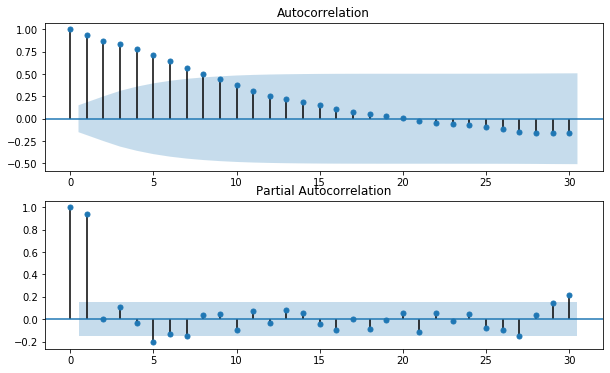

In [23]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from matplotlib import pyplot

pyplot.figure()
pyplot.subplot(211)
plot_acf(y, ax=pyplot.gca(), lags = 30)
pyplot.subplot(212)
plot_pacf(y, ax=pyplot.gca(), lags = 30)
pyplot.show()

Autocorrelation plot shows describes how well the present value of the time series is related with its past values. If the time series is stationary, the plot wil show a quick drop-off in correlation; We can see this data is non- stationary since the values degrade more slowly.

Partial autocorrelation finds correlation of the residuals with the next lag value as we remove already found variations before we find the next correlation. The PACF plot showsa spike at lag 1 and 2, indicating that all the higher-order autocorrelations are effectively explained by the lag 1 and 2 autocorrelation. 

## 3. Time Series Forecasting With Seasonal ARIMA

### 3.1 Deviding Data Into Train And Validation Set

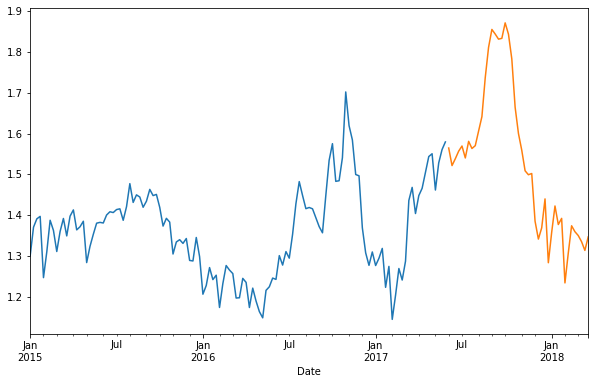

In [24]:
#divide into train and validation set
train = df[:int(0.75*(len(y)))]
valid = df[int(0.75*(len(y))):]

#plotting the data
train['AveragePrice'].plot()
valid['AveragePrice'].plot()

### 3.2 Finding The Optimal Model Using Grid Search

In [62]:
## Grid Search Using Seasonal Components  
import itertools  

p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p,d,q))]

print('Examples of parameter control combinations for Seasonal ARIMA...')
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX:{} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX:{} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter control combinations for Seasonal ARIMA...
SARIMAX:(0, 0, 1) x (0, 0, 1, 52)
SARIMAX:(0, 0, 1) x (0, 1, 0, 52)
SARIMAX:(0, 1, 0) x (0, 1, 1, 52)
SARIMAX:(0, 1, 0) x (1, 0, 0, 52)


In [63]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['AveragePrice'], order=param, seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
             #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 52)12 - AIC:434.88307379676286
ARIMA(0, 0, 0)x(0, 0, 1, 52)12 - AIC:236.28653715894853
ARIMA(0, 0, 0)x(0, 1, 0, 52)12 - AIC:-51.45760479104939
ARIMA(0, 0, 0)x(0, 1, 1, 52)12 - AIC:-10.43411166991871
ARIMA(0, 0, 0)x(1, 0, 0, 52)12 - AIC:-51.622846558908336
ARIMA(0, 0, 0)x(1, 0, 1, 52)12 - AIC:-64.46701802783117
ARIMA(0, 0, 0)x(1, 1, 0, 52)12 - AIC:-24.462352168065774
ARIMA(0, 0, 0)x(1, 1, 1, 52)12 - AIC:-20.344359476333658
ARIMA(0, 0, 1)x(0, 0, 0, 52)12 - AIC:272.01039451349226
ARIMA(0, 0, 1)x(0, 0, 1, 52)12 - AIC:144.76596062941073
ARIMA(0, 0, 1)x(0, 1, 0, 52)12 - AIC:-107.87743968076498
ARIMA(0, 0, 1)x(0, 1, 1, 52)12 - AIC:-26.037871856896906
ARIMA(0, 0, 1)x(1, 0, 0, 52)12 - AIC:-109.85820426067083
ARIMA(0, 0, 1)x(1, 0, 1, 52)12 - AIC:-115.1433294796208
ARIMA(0, 0, 1)x(1, 1, 0, 52)12 - AIC:-30.135633738483207
ARIMA(0, 0, 1)x(1, 1, 1, 52)12 - AIC:-16.000991036430367
ARIMA(0, 1, 0)x(0, 0, 0, 52)12 - AIC:-380.296049999481
ARIMA(0, 1, 0)x(0, 0, 1, 52)12 - AIC:-205

In [64]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                  126
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 192.337
Date:                Tue, 07 Apr 2020   AIC                           -380.674
Time:                        19:15:53   BIC                           -375.018
Sample:                    01-04-2015   HQIC                          -378.376
                         - 05-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0010      0.003    296.536      0.000       0.994       1.008
sigma2         0.0027      0.000      9.098      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       47.33   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.20   Prob(JB):                         0.16
Heteroskedasticity (H):               2.31   Skew:                            -0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

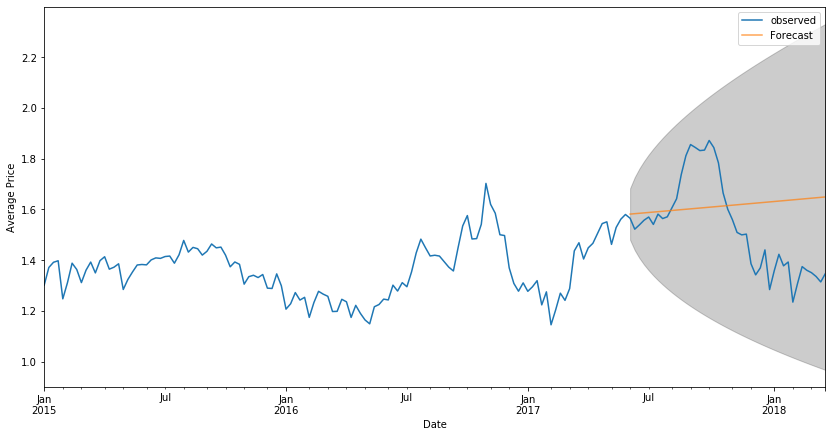

In [65]:
start_index = valid.index.min()
end_index = valid.index.max()

# Apply the optimal model on validation set 
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)


pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.show()


In [27]:
## Grid Search Using Seasonal Components  
import itertools  

p = d = q = range(0,2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

print('Examples of parameter control combinations for Seasonal ARIMA...')
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX:{} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX:{} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX:{} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter control combinations for Seasonal ARIMA...
SARIMAX:(0, 0, 1) x (0, 0, 1, 12)
SARIMAX:(0, 0, 1) x (0, 1, 0, 12)
SARIMAX:(0, 1, 0) x (0, 1, 1, 12)
SARIMAX:(0, 1, 0) x (1, 0, 0, 12)


In [36]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train['AveragePrice'], order=param, seasonal_order=param_seasonal, 
                                            enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
             #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:434.88307379676286
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:284.14005834187117
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-90.36886676062502
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-118.60666900937079
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-90.03914868004142
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-138.75123252606724
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-89.16946008288109
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-110.9963034278637
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:272.01039451349226
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:143.0058833530752
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-173.05153987201507
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-196.99823091917733
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-175.21582181985374
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-223.18134682993548
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-176.90826482355783
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-189.57410768451862
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-380.296049999481
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-347.

The parameters of the optimal model with the lowest AIC are (1,0,0) x (0,0,0,12)   

In [61]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                  126
Model:               SARIMAX(1, 0, 0)   Log Likelihood                 192.337
Date:                Tue, 07 Apr 2020   AIC                           -380.674
Time:                        18:06:29   BIC                           -375.018
Sample:                    01-04-2015   HQIC                          -378.376
                         - 05-28-2017                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0010      0.003    296.536      0.000       0.994       1.008
sigma2         0.0027      0.000      9.098      0.000       0.002       0.003
===================================================================================
Ljung-Box (Q):                       47.33   Jarque-Bera (JB):                 3.69
Prob(Q):                              0.20   Prob(JB):                         0.16
Heteroskedasticity (H):               2.31   Skew:                            -0.23
Prob(H) (two-sided):                  0.01   Kurtosis:                         3.70
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [38]:
start_index = valid.index.min()
end_index = valid.index.max()

# Apply the optimal model on validation set 
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

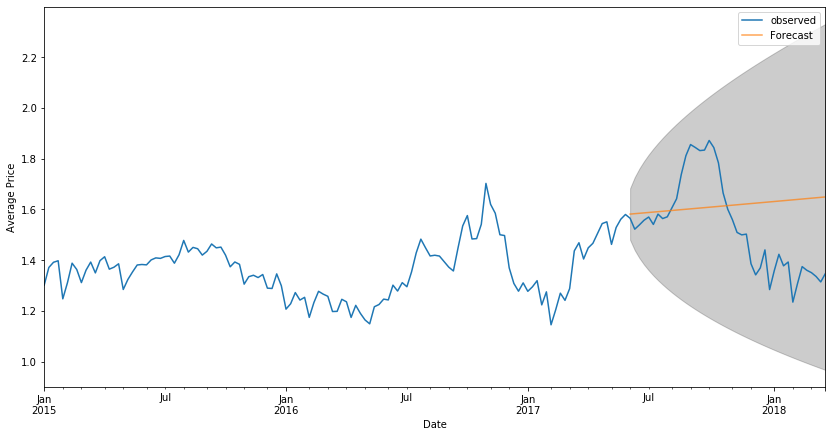

In [48]:
pred_ci = pred.conf_int()
ax = y['2015':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.show()

The model predicts the average price of avacados will go up from roughly 1.6 to 1.7 during the period of 9 months despite the variation of seasonality.

### 3.3 Model Evaluation

Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved. 

Based on the model diagnostics, we can see the resisuals of the model are normally distributed and have correlations with each other. 

- The stardard resisual plot (top left) shows that the residuals over time doesn't have any obvious seasonality.
- In the top right plot, the KDE line follows closely to the N(0.1) line which is the standard notation for a normal distribution with mean 0 and standard deviation of 1. 
- The qq plot (bottom left) shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution.
- In the correlogram plot (bottom right) shows that time series of residuals have low correlations with its previous lags.  


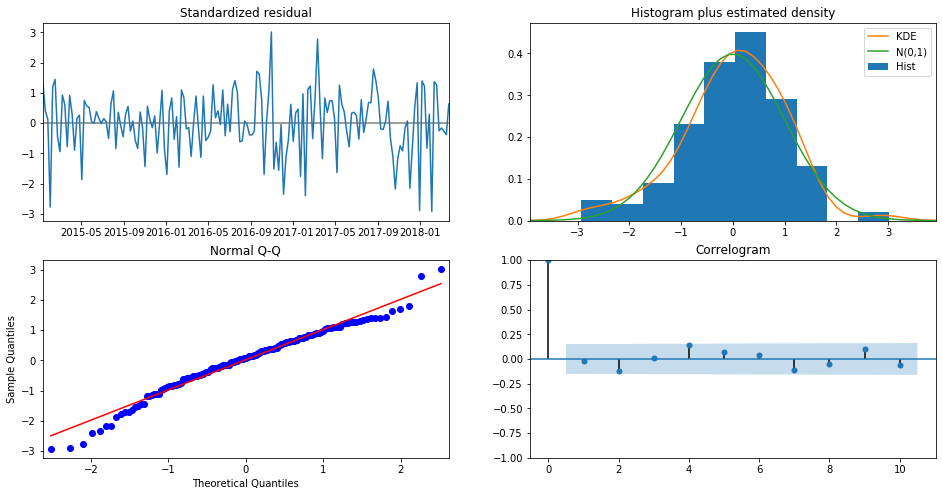

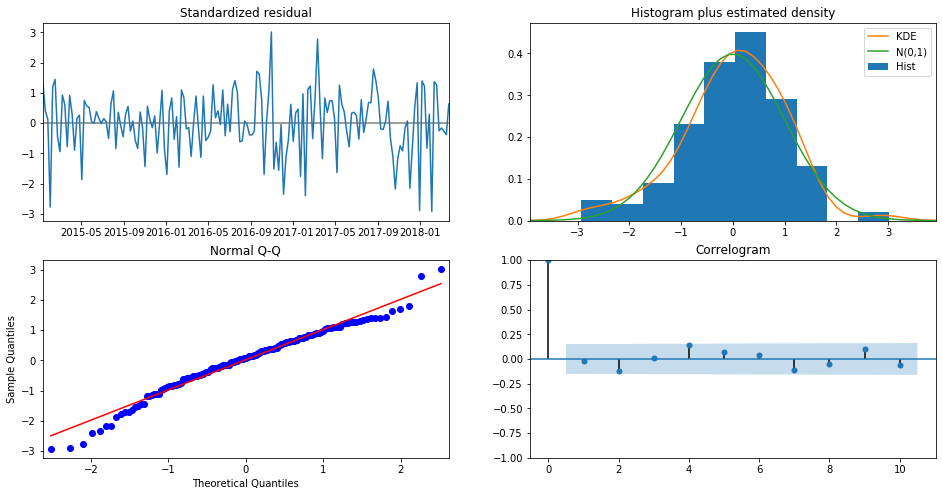

In [49]:
results.plot_diagnostics(figsize=(16, 8))

In [53]:
y_forecasted = pred.predicted_mean.values
y_truth = valid['AveragePrice'].values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 0.04


In [54]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 0.21


In [57]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

evaluate_forecast(y_truth, y_forecasted)

,r2_score,mean_absolute_error,median_absolute_error,mse,msle,rmse
0,-0.34884,0.176465,0.211074,0.044422,0.006917,0.210766


### 3.4 Forecasting 

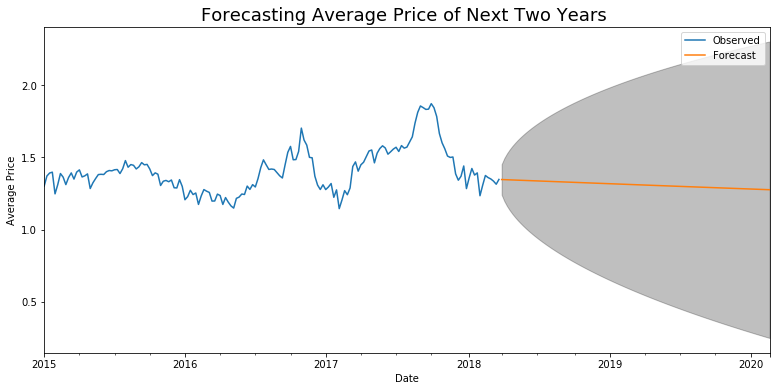

In [59]:
forecast = results.get_forecast(steps=100)
pred_ci = forecast.conf_int()
ax = y.plot(label='Observed', figsize=(13, 6))
forecast.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Date')
ax.set_ylabel('Average Price')
plt.legend()
plt.title('Forecasting Average Price of Next Two Years ',fontsize=18)
plt.show()

## 4. Actionable Recommendations

### 4.1 Summary Of Findings

- Avocados are the cheapest in the winter and the most expensive in the fall. 
- Type of avocados doesn't have a significant impact on the fluctuation of price. Average price of organic avocados has always been about 50 cents more than conventional ones. 
- Avocado prices are the highest at the end of each month. 
- Avocados are cheaper in the south central region such as Texas and California.
- Avocado prices are the highest in 2017, but also fluctuate the most in that year due to a surging demand and a smaller crop in California and Mexico.

- Based on the forecast, avocado prices will slightly decline over 2018 and 2019 and the average price will not be more than 1.5. However, the price of avocados is largely influenced by the harvest in California and Mexico, as well as trade tariffs. Surging price in a single year due to weather or political event is likely to happen.


### 4.2 Recommendations For Avocado Lovers:

Early summer is the best time to stock up on avocados. Prices are likely to go up in September. However, freezing can affect the texture. The possible solution is to blend thawed avocados into guacamole and other dishes and you can enjoy it till November. By then, prices will significantly decrease and stay low till spring.   

It might not be worth the money to buy organic avocados since organic avocados are at least 50 cents more expensive then conventional ones.The main reason that people purchase organic products is to avoid pesticides. There are fruits or vegetables that are likely to absorb pesticides such as peaches and apples. But it may not be the case for avocados because we don't eat the skin, where pesticides may have directly touched. 